In [2]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/BaTagging


In [3]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import copy
import time

import scipy.optimize as opt

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (12,9)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Import the nEXO sensitivity classes
import nEXOMaterialsDBInterface
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib
importlib.reload( nEXOMaterialsDBInterface )
importlib.reload( nEXOFitWorkspace )
importlib.reload( nEXOFitModel )

<module 'nEXOFitModel' from '../../../modules/nEXOFitModel.py'>

In [54]:
def ComputeHalflifeFromNumCounts( counts ):
    
    # Returns the half life which would give (on average) the input number of signal counts
    
    N_A = 6.02e23 # atoms/mol
    FidMass = 3281 # kg
    AtomicMass = 135.8 # g/mol
    EnrichmentFraction = 0.9
    SigEfficiency = 0.96
    Livetime = 10 # years
    
    return FidMass*1.e3 / AtomicMass * N_A * EnrichmentFraction * Livetime * \
            SigEfficiency * np.log(2) / counts

# Scaling study

There is some uncertainty as to why our median projected sensitivity for the 2nu-only case is *better* than a 0-bkg counting experiment. Our intuition tells us that this may have something to do with a counter-intuitive property of the median; the limit on signal counts can improve with increasing background, due to the median being fixed at a discrete number of counts. This has been demonstrated in many places:
* Feldman-Cousins (though they don't show it explicitly)
* Jelle Aalbers' thesis
* Bhattiprolu et al. 2020 (arXiv:2009.07249)

#### Our strategy

To study this, I'll repeat the sensitivity calculation for the 2-nu-only case with different scaling factors applied to the 2nu spectrum. We will see if the median sensitivity changes in a non-monotonic manner with the scaling factor. 

Intiuitively, the sensitivity *should* get worse as the background scaling increases. Let's see if this is indeed the case.


## Load the critical lambda data


In [5]:
# Generate a list of the file names

critical_lambda_dir = '/p/lustre2/lenardo1/sensitivity_output/'+\
            'Dec20_2020_CriticalLambda_ba_tagging_background_scaling/'

all_files = os.listdir( critical_lambda_dir )

h5_files = [filename for filename in all_files \
            if filename.endswith('h5') ]


In [6]:
# Get the calculation points from the filenames

signal_points = [float(filename.split('_')[-5]) for filename in h5_files]
scaling_factors = [filename.split('_')[-2] for filename in h5_files]

# Find unique values using set
signal_points_set = set(signal_points)
signal_points = list(signal_points_set)
signal_points = sorted(signal_points)
#print(signal_points)

scaling_factors_set = set(scaling_factors)
scaling_factors = list(scaling_factors_set)
scaling_factors = sorted(scaling_factors)


In [7]:
# Load the data
LOAD_DATA = False

if LOAD_DATA:
    
    critical_lambdas_dict = {}
    start_time = time.time()

    for scaling_factor in scaling_factors:
        
        #if not scaling_factor == '1e-06': continue

        print('Loading files for scaling factor {:4.4} at {:4.4} min'.format(\
                                        float(scaling_factor),(time.time()-start_time)/60.))

        h5_files_scaling = [filename for filename in h5_files \
                           if filename.split('_')[-2] == scaling_factor]

        critical_lambdas_vs_signal = []

        counter = 0
        for signal_point in signal_points:

            if counter % 8 == 0:
                print('-----> Loading {:5.5}'.format(signal_point))

            h5_files_this = [filename for filename in h5_files_scaling\
                            if float(filename.split('_')[-5]) == signal_point]

            this_df_list = [pd.read_hdf(critical_lambda_dir+filename) \
                            for filename in h5_files_this]
            try:
                this_df = pd.concat(this_df_list,ignore_index=True)
            except ValueError as e:
                print(e)
                critical_lambdas_vs_signal.append(0.)
                continue

            this_critical_lambda = np.quantile(this_df['lambda'].values,0.9)

            critical_lambdas_vs_signal.append(this_critical_lambda)

            counter += 1

        critical_lambdas_dict[scaling_factor] = critical_lambdas_vs_signal


In [8]:
if LOAD_DATA:
    with open('CriticalLambdaCurves/scaling_study_critical_lambda_curves_dict.pkl','wb') as outfile:
        pickle.dump(critical_lambdas_dict,outfile)
        
else:
    with open('CriticalLambdaCurves/scaling_study_critical_lambda_curves_dict.pkl','rb') as infile:
        critical_lambdas_dict = pickle.load(infile)
        

## Plot the critical lambda curves

0.0001
0.01
00.5
01.0
01.5
02.0
1e-06


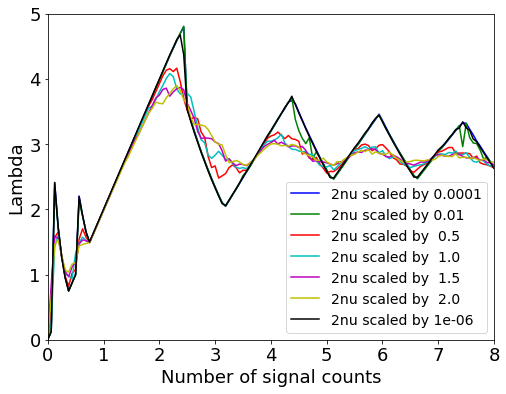

In [9]:
# Plot and also save the critical lambda curves as text files
SAVE_AS_TEXT = False


plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

for factor, array in critical_lambdas_dict.items():
    
    
    if factor == '03.0' or factor == '1.25' or factor == '0.75': continue
    print(factor)
    
    if False:
    #if factor == '1e-06':
        plt.plot(signal_points[::2],array[::2],\
             label='2nu scaled by {:4.4}'.format(float(factor)))
    else:
        plt.plot(signal_points,array,\
             label='2nu scaled by {:4.4}'.format(float(factor)))
    
    
    
    if SAVE_AS_TEXT:
        if factor == '1e-06':
            signal_points_copy = copy.copy(signal_points[::2])
            critical_lambda_copy = copy.copy(array[::2])
        else:
            signal_points_copy = copy.copy(signal_points)
            critical_lambda_copy = copy.copy(array)
            
        signal_points_copy.append(20.)
        critical_lambda_copy.append(2.706)
        stacked_arrays = np.vstack( [np.array(signal_points_copy),\
                                    np.array(critical_lambda_copy)] )
        np.savetxt('CriticalLambdaCurves/critical_lambda_2nu_scaling_study_{}.txt'.format(factor),\
                  np.transpose(stacked_arrays))
    
plt.legend(fontsize=14,loc='lower right')
plt.xlabel('Number of signal counts')
plt.ylabel('Lambda')
plt.ylim(0.,5.)
plt.xlim(0.,8.)
plt.savefig('Plots/critical_lambda_curves_different_scalings.png',\
           dpi=200,bbox_inches='tight')


0.0001
0.01
0.75
00.5
01.0
01.5
02.0
03.0
1.25
1e-06


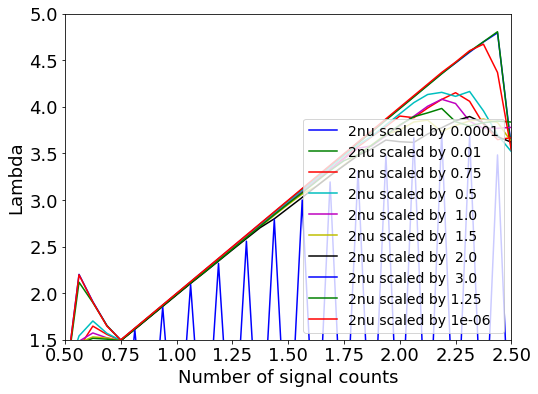

In [10]:
# Plot again, with zooming

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

for factor, array in critical_lambdas_dict.items():
    print(factor)
    plt.plot(signal_points,array,\
             label='2nu scaled by {:4.4}'.format(float(factor)))
    
    
plt.legend(fontsize=14,loc='lower right')
plt.xlabel('Number of signal counts')
plt.ylabel('Lambda')
plt.ylim(1.5,5.)
plt.xlim(0.5,2.5)
plt.savefig('Plots/critical_lambda_curves_different_scalings.png',\
           dpi=200,bbox_inches='tight')




### A quick note:
It might be an issue that we're only calculating the critical lambda at ~0.063-point intervals. You can see that this effectively smooths out the curve, since it removes the steep jumps observed in the **1.0** case at around 1.75. We can also see some discrete jumps between lines when comparing the 1.0 case, the 1.25 case, and the 1.5 case.

## Plotting the upper limits


In [11]:
output_parent_dir = '/p/lustre2/lenardo1/sensitivity_output/'
output_dir = output_parent_dir + \
                'Jan1_2021_90CL_ba_tagging_finer_spacing_interp1d_scaling_study/'

limits_files = [filename for filename in os.listdir(output_dir) \
                    if filename.endswith('.h5')]

limits_scale_factors = list( \
                            set( \
                                [ filename.split('_')[-3] for filename in limits_files ]\
                               ) \
                           )


In [12]:
LOAD_DATA_FROM_H5 = True

import time

start = time.time()

if LOAD_DATA_FROM_H5:
    
    limits_df_dict = {}

    for scale_factor in limits_scale_factors:
        print('Loading data for {} at {:4.4} min'.format(\
                                        scale_factor,(time.time()-start)/60.))

        this_df_list = []
        
        for filename in limits_files:
            if scale_factor in filename:
                this_df_list.append(pd.read_hdf(output_dir+filename))
                #print('\t{}'.format(filename))
                
        limits_df_dict[scale_factor] = pd.concat(this_df_list,ignore_index=True)


Loading data for 001.5 at 2.003e-06 min
Loading data for 00.75 at 0.1777 min
Loading data for 00.01 at 0.3255 min
Loading data for 002.0 at 0.47 min
Loading data for 001.0 at 0.6186 min
Loading data for 0.0001 at 0.7662 min
Loading data for 1e-06 at 2.797 min
Loading data for 000.5 at 4.76 min
Loading data for 01.25 at 4.921 min


In [13]:
# Get an index array which sorts these in ascending order
keys_list = [key for key in limits_df_dict.keys()]
float_keys =  np.array([float(key) for key in keys_list])
keys_sorted_idx = np.argsort(np.argsort(float_keys))

# print(keys_list)

# #print(float_keys[keys_sorted_idx])
# print(np.array(keys_list))
# print(keys_sorted_idx)
# print(np.array(keys_list)[keys_sorted_idx])


In [14]:
limits_df_dict['00.01'].head()

,90CL_crossing,best_fit_converged,best_fit_covar,best_fit_iterations,fixed_fit_acc_covar,fixed_fit_converged,lambda,num_iterations,num_signal
0,2.190274,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[1.991633325815201e-06, 0.4974850771250203, 0....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 0.250001, 0.500001, 0.750001, 1.000001..."
1,2.135267,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[1.9902363419532776e-06, 0.4975461312569678, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 0.250001, 0.500001, 0.750001, 1.000001..."
2,2.317790,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[1.989188604056835e-06, 0.4964275642996654, 0....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 0.250001, 0.500001, 0.750001, 1.000001..."
3,2.200275,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[1.989537850022316e-06, 0.49739666015375406, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 0.250001, 0.500001, 0.750001, 1.000001..."
4,2.205276,True,True,1,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[1.987558789551258e-06, 0.49735793902073056, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1e-06, 0.250001, 0.500001, 0.750001, 1.000001..."


In [15]:
print(len(limits_df_dict))
        
        

9


7
4
2
8
5
1
0
3
6


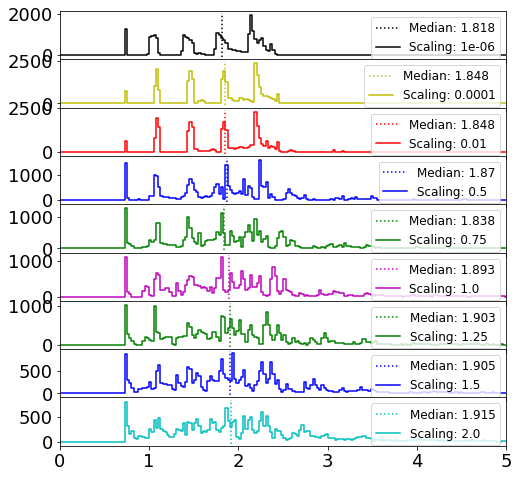

In [16]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,8)

#print(len(limits_df_dict.keys()))

fig, ax = plt.subplots(nrows=int(len(limits_df_dict.keys())),\
                     ncols=1,\
                     sharex=True,\
                     gridspec_kw={'hspace':0})

counter = 0

medians_dict = {}

for scale_factor, df in limits_df_dict.items():
    
    this_idx = keys_sorted_idx[counter]
    print(this_idx)
    
    if counter > len(colors)-1:
        color_idx = counter % len(colors)
    else:
        color_idx = counter
    
    # The mask is kind of unnecessary; essentially all the fits converge.
    mask = df['best_fit_covar']
    hist = hl.hist(df['90CL_crossing'].loc[mask],bins=np.linspace(0.,10.,400))
    median = np.median(df['90CL_crossing'].loc[mask])
    hl.plot1d(ax[this_idx],hist,color=colors[color_idx],\
              label='Scaling: {:.4}'.format(float(scale_factor)))
    
    xmed = np.ones(10)*median
    ymed = np.linspace(ax[this_idx].get_ylim()[0],\
                      ax[this_idx].get_ylim()[1],\
                      10)
    ax[this_idx].plot(xmed,ymed,':',color=colors[color_idx],\
                      label='Median: {:.4}'.format(median))
    
    ax[this_idx].legend(fontsize=12,loc='upper right')
    ax[this_idx].set_xlim(0.,5.)
    #ax[this_idx].set_yscale('log')
    
    medians_dict[scale_factor] = median
    
    counter += 1
    
    
    

plt.savefig('Plots/scaling_study_upper_limits_without_offset.png',\
            dpi=200,bbox_inches='tight')





Text(0, 0.5, 'Median 90% Upper Limit')

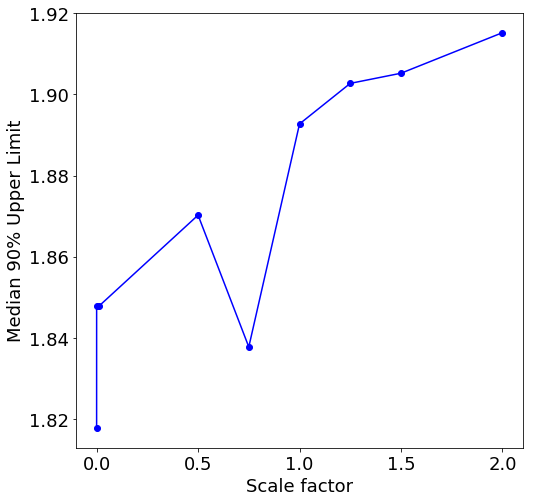

In [17]:
# Plot the medians vs. scaling factor

median_points = []
median_values = []

for point, value in medians_dict.items():
    median_points.append(float(point))
    median_values.append(value)
    
median_points = np.array(median_points)
median_values = np.array(median_values)

sorted_idx = np.argsort(median_points)

median_points = median_points[sorted_idx]
median_values = median_values[sorted_idx]

plt.plot(median_points,median_values,'-o')
plt.xlabel('Scale factor')
plt.ylabel('Median 90% Upper Limit')





(0.5, 2.6)

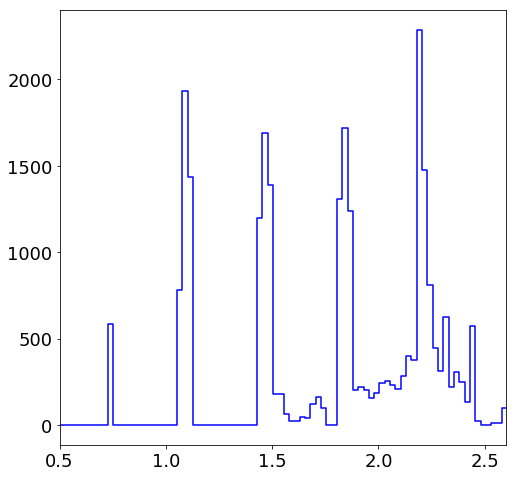

In [18]:
df = limits_df_dict['00.01']
mask = df['best_fit_covar']
hist = hl.hist(df['90CL_crossing'].loc[mask],bins=np.linspace(0.,10.,400))
hl.plot1d(hist)
plt.xlim(0.5,2.6)


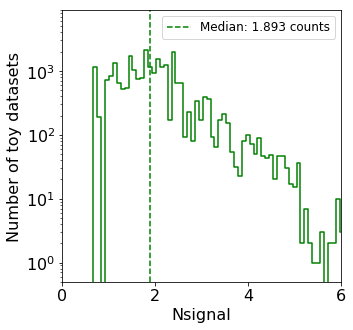

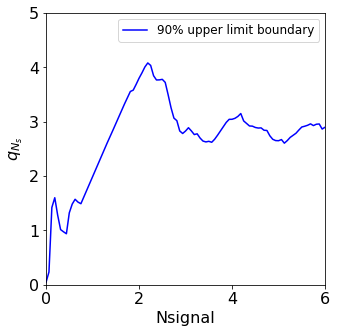

In [53]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = (5,5)
df = limits_df_dict['001.0']
mask = df['best_fit_covar']
hist = hl.hist(df['90CL_crossing'].loc[mask],bins=np.linspace(0.,10.,120))


#fig,ax = plt.subplots(ncols=2,nrows=1)


hl.plot1d(hist,color='g')
plt.gca().set_xlim(0.,6.)
plt.gca().set_ylim(0.5,9e3)
plt.gca().set_yscale('log')

median = medians_dict['001.0']

xmed = np.ones(10)*median
ymed = np.linspace(plt.gca().get_ylim()[0],\
                  plt.gca().get_ylim()[1],\
                  10)
plt.gca().plot(xmed,ymed,'--',color='g',\
                  label='Median: {:.4} counts'.format(median))

plt.xlabel('Nsignal')
plt.ylabel('Number of toy datasets')
plt.legend(loc='upper right',fontsize=12)

plt.savefig('Plots/ba_tagging_distribution_of_upper_limits_at_x1_scaling.png',\
           dpi=200,bbox_inches='tight')

plt.figure(2)

plt.plot(signal_points,critical_lambdas_dict['01.0'],'-b',label='90% upper limit boundary')
plt.xlabel('Nsignal')
plt.ylabel(r'$q_{N_s}$')
plt.xlim(0.,6.)
plt.ylim(0.,5.)
plt.legend(fontsize=12)
plt.savefig('Plots/critical_lambda_curve_ba_tagging_at_x1_scaling.png',\
           dpi=200,bbox_inches='tight')








# Where does the precision issue come into play?

The hypothesis scan for a 0-bkg experiment is just $q_\mu = 2\mu$. So let's see at which point it breaks down, and by how much.

## In the 0.0001 case

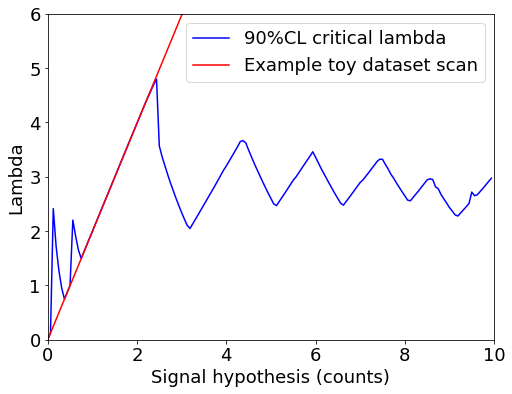

In [19]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)


plt.plot(signal_points,critical_lambdas_dict['0.0001'],'-b',label='90%CL critical lambda')
plt.plot(df['num_signal'].iloc[0],df['lambda'].iloc[0],'-r',label='Example toy dataset scan')

plt.xlabel('Signal hypothesis (counts)')
plt.ylabel('Lambda')
plt.xlim(0.,10)
plt.ylim(0.,6.)
plt.legend()

plt.savefig('Plots/precision_issue_example_toy.png',dpi=200,bbox_inches='tight')




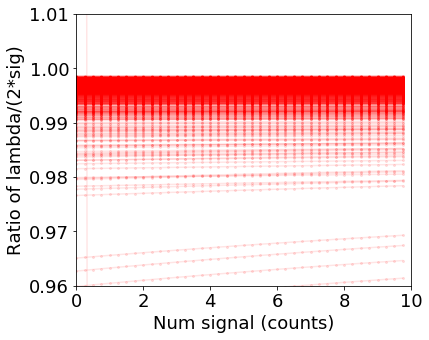

In [20]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (6,5)

df = limits_df_dict['0.0001']

df.columns

counter = 0

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
        
    plt.plot(x,y,'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    
    counter += 1
    
plt.xlim(0.,10.)
plt.ylim(0.96,1.01)

plt.xlabel('Num signal (counts)')
plt.ylabel('Ratio of lambda/(2*sig)')

plt.savefig('Plots/precision_issue_lambda_curves_ratios.png',dpi=200,bbox_inches='tight')






/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


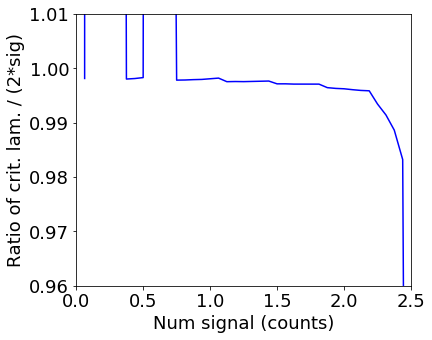

In [21]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (6,5)

x = np.array(signal_points)
y = np.array(critical_lambdas_dict['0.0001'])/(2*x)

plt.plot(x,y,'-b')

plt.xlim(0.,2.5)
plt.ylim(0.96,1.01)

plt.ylabel('Ratio of crit. lam. / (2*sig)')

plt.xlabel('Num signal (counts)')

plt.savefig('Plots/precision_issue_ratio_of_critical_lambda.png',\
            dpi=200,bbox_inches='tight')







/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


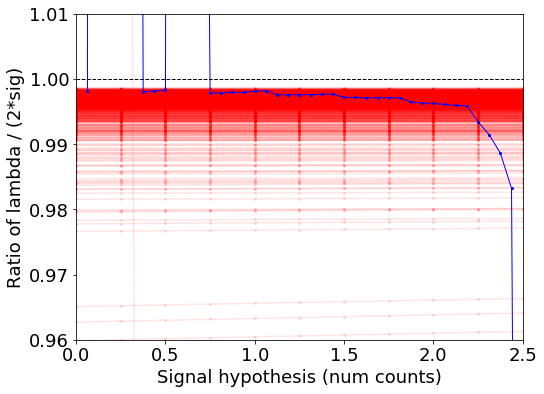

In [22]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

df = limits_df_dict['0.0001']

df.columns

counter = 0

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
        
    plt.plot(x,y,'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    
    counter += 1
    
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['0.0001'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)
    
plt.xlim(0.,2.5)
plt.ylim(0.96,1.01)

#xlim = 2.44
xlimvals = np.linspace(0.,2.5,10) #np.ones(10)*xlim
ylimvals = np.ones(10)
# ylimvals = np.linspace(plt.gca().get_ylim()[0],
#                       plt.gca().get_ylim()[1],10)
plt.plot(xlimvals,ylimvals,'--k',linewidth=1)



plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel('Ratio of lambda / (2*sig)')

plt.savefig('Plots/precision_issue_plotted_together_0.0001.png',dpi=200,bbox_inches='tight')




## In the 0.01 case

/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


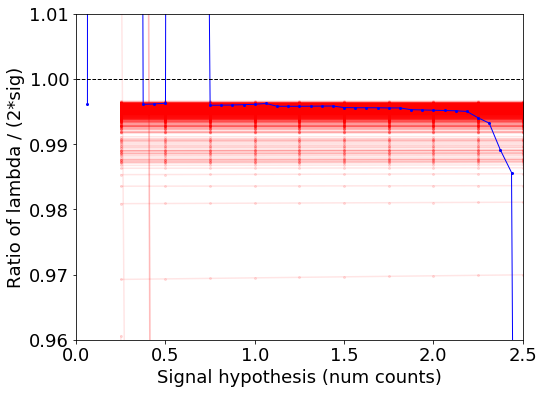

In [23]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

df = limits_df_dict['00.01']

df.columns

counter = 0

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
        
    plt.plot(x[1:],y[1:],'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    
    counter += 1
    
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['0.01'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)
    
plt.xlim(0.,2.5)
plt.ylim(0.96,1.01)

#xlim = 2.44
xlimvals = np.linspace(0.,2.5,10) #np.ones(10)*xlim
ylimvals = np.ones(10)
# ylimvals = np.linspace(plt.gca().get_ylim()[0],
#                       plt.gca().get_ylim()[1],10)
plt.plot(xlimvals,ylimvals,'--k',linewidth=1)

plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel('Ratio of lambda / (2*sig)')

plt.savefig('Plots/precision_issue_plotted_together_0.01.png',dpi=200,bbox_inches='tight')




/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


(0.96, 1.01)

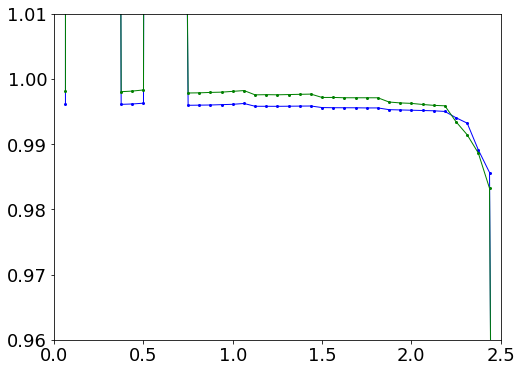

In [24]:
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['0.01'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)

x = np.array(signal_points)
y = np.array(critical_lambdas_dict['0.0001'])/(2*x)

plt.plot(x,y,'-og',markersize=2,linewidth=1)

plt.xlim(0.,2.5)
plt.ylim(0.96,1.01)
    


## In the 1.0 case

dict_keys(['001.5', '00.75', '00.01', '002.0', '001.0', '0.0001', '1e-06', '000.5', '01.25'])
dict_keys(['0.0001', '0.01', '0.75', '00.5', '01.0', '01.5', '02.0', '03.0', '1.25', '1e-06'])
Index(['90CL_crossing', 'best_fit_converged', 'best_fit_covar',
       'best_fit_iterations', 'fixed_fit_acc_covar', 'fixed_fit_converged',
       'lambda', 'num_iterations', 'num_signal'],
      dtype='object')


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


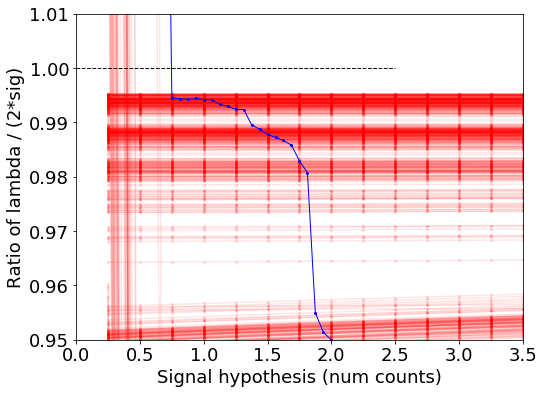

In [25]:
print(limits_df_dict.keys())
print(critical_lambdas_dict.keys())

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

df = limits_df_dict['001.0']

print(df.columns)

counter = 0

lambda_zeros = []

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
    if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar']):
        continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
    
        
    plt.plot(x[1:],y[1:],'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    lambda_zeros.append(row['lambda'][0])
    
    counter += 1
    
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['01.0'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)
    
plt.xlim(0.,3.5)
plt.ylim(0.95,1.01)

#xlim = 2.44
xlimvals = np.linspace(0.,2.5,10) #np.ones(10)*xlim
ylimvals = np.ones(10)
# ylimvals = np.linspace(plt.gca().get_ylim()[0],
#                       plt.gca().get_ylim()[1],10)
plt.plot(xlimvals,ylimvals,'--k',linewidth=1)

plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel('Ratio of lambda / (2*sig)')

plt.savefig('Plots/precision_issue_plotted_together_1.0.png',dpi=200,bbox_inches='tight')




## In the 2.0 case

dict_keys(['001.5', '00.75', '00.01', '002.0', '001.0', '0.0001', '1e-06', '000.5', '01.25'])
dict_keys(['0.0001', '0.01', '0.75', '00.5', '01.0', '01.5', '02.0', '03.0', '1.25', '1e-06'])
Index(['90CL_crossing', 'best_fit_converged', 'best_fit_covar',
       'best_fit_iterations', 'fixed_fit_acc_covar', 'fixed_fit_converged',
       'lambda', 'num_iterations', 'num_signal'],
      dtype='object')


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


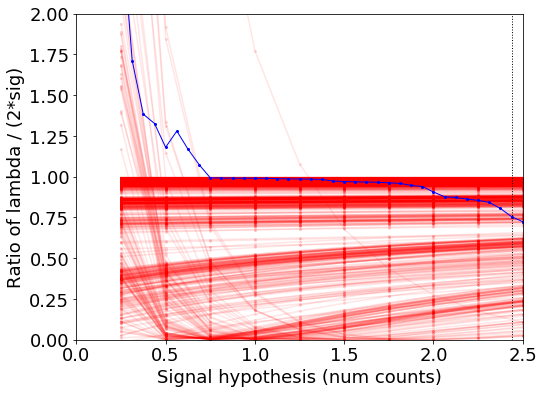

In [26]:
print(limits_df_dict.keys())
print(critical_lambdas_dict.keys())

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

df = limits_df_dict['002.0']

print(df.columns)

counter = 0

lambda_zeros = []

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
    if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar']):
        continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
    
        
    plt.plot(x[1:],y[1:],'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    lambda_zeros.append(row['lambda'][0])
    
    counter += 1
    
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['02.0'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)
    
plt.xlim(0.,2.5)
plt.ylim(0.,2.0)

xlim = 2.44
xlimvals = np.ones(10)*xlim
ylimvals = np.linspace(plt.gca().get_ylim()[0],
                      plt.gca().get_ylim()[1],10)
plt.plot(xlimvals,ylimvals,':k',linewidth=1)

plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel('Ratio of lambda / (2*sig)')

plt.savefig('Plots/precision_issue_plotted_together_2.0.png',dpi=200,bbox_inches='tight')




dict_keys(['001.5', '00.75', '00.01', '002.0', '001.0', '0.0001', '1e-06', '000.5', '01.25'])
dict_keys(['0.0001', '0.01', '0.75', '00.5', '01.0', '01.5', '02.0', '03.0', '1.25', '1e-06'])
Index(['90CL_crossing', 'best_fit_converged', 'best_fit_covar',
       'best_fit_iterations', 'dataset', 'fixed_fit_acc_covar',
       'fixed_fit_converged', 'lambda', 'num_iterations', 'num_signal'],
      dtype='object')


/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


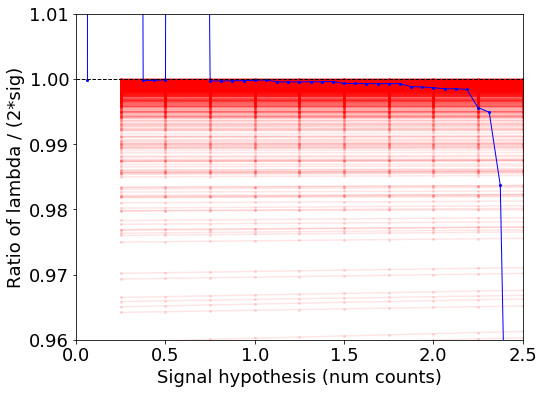

In [29]:
print(limits_df_dict.keys())
print(critical_lambdas_dict.keys())

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

df = limits_df_dict['1e-06']

print(df.columns)

counter = 0

lambda_zeros = []

for index, row in df.iterrows():
    if counter > 1000:
        break
        
    if not row['best_fit_covar']: continue
    if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar']):
        continue
        
    x = row['num_signal']
    y = row['lambda'] / (2 * x)
    
        
    plt.plot(x[1:],y[1:],'-o',color=(1.,0.,0.,0.1),markersize=2)
    
    lambda_zeros.append(row['lambda'][0])
    
    counter += 1
    
x = np.array(signal_points)
y = np.array(critical_lambdas_dict['1e-06'])/(2*x)

plt.plot(x,y,'-ob',markersize=2,linewidth=1)
    
plt.xlim(0.,2.5)
plt.ylim(0.96,1.01)

#xlim = 2.44
xlimvals = np.linspace(0.,2.5,10) #np.ones(10)*xlim
ylimvals = np.ones(10)
# ylimvals = np.linspace(plt.gca().get_ylim()[0],
#                       plt.gca().get_ylim()[1],10)
plt.plot(xlimvals,ylimvals,'--k',linewidth=1)

plt.xlabel('Signal hypothesis (num counts)')
plt.ylabel('Ratio of lambda / (2*sig)')

plt.savefig('Plots/precision_issue_plotted_together_1e-6.png',dpi=200,bbox_inches='tight')


In [28]:
# hzeros = hl.hist(np.log10(-np.array(lambda_zeros)),bins=np.linspace(-5,1.,1000))
# hl.plot1d(hzeros)

# plt.yscale('log')
